[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/igor-davidyuk/openfl/blob/linear-regression-numpy-tutorial/openfl-tutorials/interactive_api/linear_regression/workspace/SingleNotebook.ipynb)

### Preparations in colab:
We need to clone the repository to run a federation because it contains director and envoy configs to start from.

1. clone the OpenFL repo
2. install OpenFL
3. cd to the linreg workspace

In [ ]:
!git clone https://github.com/igor-davidyuk/openfl.git -b linear-regression-numpy-tutorial
!cd openfl && pip install .

In [ ]:
import os
from time import sleep

os.chdir('./openfl/openfl-tutorials/interactive_api/linear_regression/workspace')

# Linear Regression with Numpy and OpenFL

In [ ]:
from typing import List, Union
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 7, 5

# We will use MSE as loss function and Ridge weights regularization
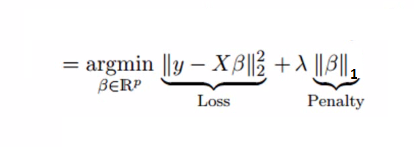

In [ ]:
class LinRegLasso:
    def __init__(self, n_feat: int) -> None:
        self.weights = np.ones((n_feat + 1)) # (n_feat + 1,) weights + bias
        
    def predict(self, feature_vector: Union[np.ndarray, List[int]]) -> float:
        '''
        feature_vector may be a list or have shape (n_feat,)
        or it may be a bunch of vectors (n_vec, nfeat)
        '''
        feature_vector = np.array(feature_vector)
        if len(feature_vector.shape) == 1:
            feature_vector = feature_vector[:,np.newaxis]
        assert feature_vector.shape[-1] == self.weights.shape[0] - 1, \
            f"sample shape is {feature_vector.shape} and weights shape is f{self.weights}"
        
        return self.weights @ np.concatenate((feature_vector.T, [[1]*feature_vector.shape[0]]))
    
    def mse(self, X: np.ndarray, Y: np.ndarray) -> float:
        Y_hat = self.predict(X)
        return np.sum((Y - Y_hat)**2) / Y.shape[0]

    def _update_weights(self, X: np.ndarray, Y: np.ndarray, lr: float, wd: float) -> None:
        '''
        X: (n_samples, n_features)
        Y: (n_samples,)
        self.weights: (n_features + 1)
        
        Cost function is MSE: (y - W*X - b)**2;
        its derivative with resp to any x is -2*X*(y - W*X - b),
        and with resp to b is -2*(y - W*X - b).
        
        Regularisation function is L1 |W|;
        its derivative is SIGN(w)
        '''
        predictions = self.predict(X)
        error = Y - predictions # (n_samples,)
        X_with_bias = np.concatenate((X.T, [[1]*X.shape[0]])).T
        updates = -2 * X_with_bias.T @ error / Y.shape[0]
        regression_term = np.sign(self.weights)
        
        self.weights = self.weights - lr * updates + wd * regression_term
    
    def fit(self, X: np.ndarray, Y: np.ndarray,
            n_epochs: int, lr: float, wd: float,
            silent: bool=False) -> None:
        for i in range(n_epochs):
            self._update_weights(X, Y, lr, wd)
            mse = self.mse(X, Y)
            if not silent:
                print(f'epoch: {i}, \t MSE: {mse}')
            

In [ ]:
#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
# plt.plot(x,y,'.')

In [ ]:
lr_model = LinRegLasso(1)
wd = 0.0001
lr = 0.08
epochs = 100

print(f"Initila MSE: {lr_model.mse(x,y)}")
lr_model.fit(x[:,np.newaxis],y, epochs, lr, wd, silent=True)
print(f"Final MSE: {lr_model.mse(x,y)}")
print(f"Final parameters: {lr_model.weights}")

In [ ]:
# We can also solve this 1D problem using Numpy
numpy_solution = np.polyfit(x,y,1)
predictor_np = np.poly1d(numpy_solution)

In [ ]:
y_hat = lr_model.predict(x)
y_np = predictor_np(x)
plt.plot(x,y,'.')
plt.plot(x,y_hat,'.')
plt.plot(x,y_np,'--')

# Now we run the same training on federated data

## 1. Start the Director service and several envoys with generated data

In [ ]:
# Here are the main parameters for our Federation
n_cols=10
n_samples_per_col=10
noise=0.2

In [2]:
import os
from pathlib import Path
import yaml
from typing import Dict, List, Union

### Start the Director service

In [ ]:
cwd = Path.cwd()
director_workspace_path = Path('../director/').absolute()
director_config_file = director_workspace_path / 'director_config.yaml'
director_logfile = director_workspace_path / 'director.log'
if director_logfile.is_file(): director_logfile.unlink()

os.environ['main_folder'] = str(cwd)
os.environ['director_workspace_path'] = str(director_workspace_path)
os.environ['director_logfile'] = str(director_logfile)
os.environ['director_config_file'] = str(director_config_file)

In [ ]:
%%script /bin/bash --bg
cd $director_workspace_path
fx director start --disable-tls -c $director_config_file > $director_logfile &
cd $main_folder

## Start Envoys

#### First, we create several envoy config files 

In [ ]:
# Read the original envoy config file content
with open(Path('../envoy/envoy_config.yaml'), "r") as stream:
    orig_config = yaml.safe_load(stream)

def generate_envoy_configs(config: Dict,
                           save_path: Union[str, Path] = '../envoy/',
                           n_cols: int = 10,
                           n_samples_per_col: int = 10,
                           noise: float = 0.15) -> List[Path]:

    config['shard_descriptor']['params']['n_samples'] = n_samples_per_col
    config['shard_descriptor']['params']['noise'] = noise
    
    config_paths = [(Path(save_path) / f'{i}_envoy_config.yaml').absolute()
                for i in range(1, n_cols + 1)]

    for i, path in enumerate(config_paths):
        config['shard_descriptor']['params']['rank'] = i
        with open(path, "w") as stream:
            yaml.safe_dump(config, stream)
            
    return config_paths
            
def remove_configs(config_paths):
    for path in config_paths:
        path.unlink()

In [ ]:
config_paths = generate_envoy_configs(orig_config,
                                      n_cols=n_cols,
                                      n_samples_per_col=n_samples_per_col,
                                      noise=noise)
# remove_configs(config_paths)

#### Now start Envoy processes in a loop

In [ ]:
# envoy_workspace_path = Path('../envoy/').absolute()
def start_envoys(config_paths: List[Path]) -> None:
    envoy_workspace_path = config_paths[0].parent
    cwd = Path.cwd()
    os.chdir(envoy_workspace_path)
    for i, path in enumerate(config_paths):
        os.system(f'fx envoy start -n env_{i + 1} --disable-tls '
                  f'--envoy-config-path {path} -dh localhost -dp 50049 '
                  f'>env_{i + 1}.log &')
    os.chdir(cwd)

sleep(5)

start_envoys(config_paths)

sleep(20)

## 2. Connect to the Director service of out Federation as Data scientist

In [ ]:
# Create a federation
from openfl.interface.interactive_api.federation import Federation

# please use the same identificator that was used in signed certificate
client_id = 'frontend'
director_node_fqdn = 'localhost'
director_port = 50049

federation = Federation(
    client_id=client_id,
    director_node_fqdn=director_node_fqdn,
    director_port=director_port,
    tls=False
)

In [ ]:
# Data scientist may request a list of connected envoys
shard_registry = federation.get_shard_registry()
# make sure shard registry contains all the envoys,
# in other case try rereconnecting to the Director
shard_registry

### Now we will prepare an FL experimnet using OpenFL Python API

### Data

In [ ]:
from openfl.interface.interactive_api.experiment import TaskInterface, DataInterface, ModelInterface, FLExperiment

class LinRegDataSet(DataInterface):
    def __init__(self, **kwargs):
        """Initialize DataLoader."""
        self.kwargs = kwargs
        pass

    @property
    def shard_descriptor(self):
        """Return shard descriptor."""
        return self._shard_descriptor
    
    @shard_descriptor.setter
    def shard_descriptor(self, shard_descriptor):
        """
        Describe per-collaborator procedures or sharding.

        This method will be called during a collaborator initialization.
        Local shard_descriptor  will be set by Envoy.
        """
        self._shard_descriptor = shard_descriptor
        self.train_set = shard_descriptor.get_dataset("train")
        self.val_set = shard_descriptor.get_dataset("val")

    def get_train_loader(self, **kwargs):
        """Output of this method will be provided to tasks with optimizer in contract."""
        return self.train_set

    def get_valid_loader(self, **kwargs):
        """Output of this method will be provided to tasks without optimizer in contract."""
        return self.val_set

    def get_train_data_size(self):
        """Information for aggregation."""
        return len(self.train_set)

    def get_valid_data_size(self):
        """Information for aggregation."""
        return len(self.val_set)
    
lin_reg_dataset = LinRegDataSet()

### Model

In [ ]:
framework_adapter = 'custom_adapter.CustomFrameworkAdapter'
fed_model = LinRegLasso(1)
MI = ModelInterface(model=fed_model, optimizer=None, framework_plugin=framework_adapter)

# Save the initial model state
initial_model = LinRegLasso(1)

### Tasks
Using an Optimizer does not make sense for this experiment. Yet it is a required part of a training task contract in the current version of OpenFL, so we just pass None.
We need to employ a trick reporting metrics. OpenFL decides which model is the best based on an *increasing* metric.

In [ ]:
TI = TaskInterface()

@TI.add_kwargs(**{'lr': 0.001,
                   'wd': 0.0001,
                   'epoches': 1})
@TI.register_fl_task(model='my_model', data_loader='train_data', \
                     device='device', optimizer='optimizer')     
def train(my_model, train_data, optimizer, device, lr, wd, epoches):
    X, Y = train_data[:,:-1], train_data[:,-1]
    my_model.fit(X, Y, epochs, lr, wd, silent=True)
    return {'train_MSE': my_model.mse(X, Y),}

#@TI.main_metric(name='validation_MSE', less_better=True)
@TI.register_fl_task(model='my_model', data_loader='val_data', device='device')     
def validate(my_model, val_data, device):
    X, Y = val_data[:,:-1], val_data[:,-1]        
    return {'validation_MSE': my_model.mse(X, Y),}

### Run

In [ ]:
experiment_name = 'linear_regression_experiment'
fl_experiment = FLExperiment(federation=federation, experiment_name=experiment_name,
                            )
# serializer_plugin='openfl.plugins.interface_serializer.dill_serializer.DillSerializer'


In [ ]:
fl_experiment.start(model_provider=MI, 
                    task_keeper=TI,
                    data_loader=lin_reg_dataset,
                    rounds_to_train=10,)

In [ ]:
# This method not only prints messages recieved from the director, 
# but also saves logs in the tensorboard format (by default)
fl_experiment.stream_metrics()

### Optional: start tensorboard

In [ ]:
%%script /bin/bash --bg
tensorboard --host $(hostname --all-fqdns | awk '{print $1}') --logdir logs

### 3. Retrieve the trained model from the Director

In [ ]:
last_model = fl_experiment.get_last_model()
best_model = fl_experiment.get_best_model()
print(best_model.weights)
print(last_model.weights)
print(f"last model MSE: {last_model.mse(x,y)}")
print(f"best model MSE: {best_model.mse(x,y)}")

## Lets see what does the unified dataset looks like

In [ ]:
n_cols = 20
n_samples = 4
interval = 240
x_start = 60
noise = 0.3

X = None

for rank in range(n_cols):
    np.random.seed(rank)  # Setting seed for reproducibility
    x = np.random.rand(n_samples, 1) * interval + x_start
    x *= np.pi / 180
    X = x if X is None else np.vstack((X,x))
    y = np.sin(x) + np.random.normal(0, noise, size=(n_samples, 1))
    plt.plot(x,y,'+')
    
X.sort()    
Y_hat = last_model.predict(X)
plt.plot(X,Y_hat,'--')

## Cleaning

In [ ]:
# To stop all services run
!pkill fx

In [ ]:
remove_configs(config_paths)